In [147]:
import os
import glob
import trimesh
import numpy as np

import tensorflow as tf  # For tf.data
import keras
from keras import layers
from matplotlib import pyplot as plt
from tqdm import tqdm
keras.utils.set_random_seed(seed=42)


In [148]:

OTOPLY = "otolithe"
SULCUS = "sulcus"
DATA_DIR = "otolithes"

# mesh = trimesh.load(os.path.join("sulcus", "Segmentation_05a-01.ply"))
# # # mesh.show()

In [149]:
VAL_SPLIT = 0.2
NUM_SAMPLE_POINTS = 2048
BATCH_SIZE = 2
EPOCHS = 50
INITIAL_LR = 1e-3


LABELS = ["otolithe","sulcus"]
COLORS = ["red","blue"]

In [150]:
train_points = []
test_points = []
#Ce qui nous as pris beaucoup du temps c'est de comprendre la structure des nuages de points 
point_cloud_labels, all_labels = [], []
def parse_dataset(num_points=2048):
  
    folder = "otolithe"
    sulcus_folder = "sulcus"
   
    print(f"processing class: {folder}")
    
    # Get tous les fichiers
    train_files = glob.glob(os.path.join(folder, "*"))
    sulcus_files = glob.glob(os.path.join(sulcus_folder, "*"))
    train_files = sorted(train_files)
    sulcus_files = sorted(sulcus_files)
    # Definition de la distance minimale
    distance_threshold = 0.19  # Adjust 
    for i in range(0, len(train_files)):
        
        
        pcd_otolithe = trimesh.load(train_files[i]).sample(num_points)
        pcd_sulcus = trimesh.load(sulcus_files[i]).sample(num_points)
        labels = []
        train_points.append(pcd_otolithe)
        # Etiquetage de chaque point (peut prendre du temps imprevu)
        for i, point_oto1 in enumerate(pcd_otolithe):
            distances = np.linalg.norm(pcd_sulcus - point_oto1,axis=1)
           
            min_distance = np.min(distances)
            
            if min_distance < distance_threshold:
                labels.append("sulcus")
            else:
                labels.append("otolithe")
        label_data = [
            LABELS.index(label) if label != "none" else len(LABELS)
            for label in labels
        ]
        # One-hot encoding
        label_data = keras.utils.to_categorical(label_data, num_classes=len(LABELS) + 1)
        
        point_cloud_labels.append(label_data)       
        
        all_labels.append(labels)
# train_points, test_points, train_labels, test_labels, class_map = parse_dataset(num_points=2048)

# res = parse_dataset(num_points=2048)
# print(res)
parse_dataset(2048)


processing class: otolithe


In [151]:
for p in all_labels:
    print(p)

['otolithe', 'otolithe', 'sulcus', 'sulcus', 'sulcus', 'otolithe', 'otolithe', 'sulcus', 'otolithe', 'otolithe', 'otolithe', 'sulcus', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'sulcus', 'sulcus', 'otolithe', 'otolithe', 'otolithe', 'sulcus', 'otolithe', 'otolithe', 'otolithe', 'sulcus', 'sulcus', 'sulcus', 'otolithe', 'sulcus', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'sulcus', 'sulcus', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'sulcus', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'sulcus', 'otolithe', 'sulcus', 'otolithe', 'sulcus', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'sulcus', 'otolithe', 'otolithe', 'sulcus', 'otolithe', 'sulcus', 'sulcus', 'otolithe', 'otolithe', 'sulcus', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', 'otolithe', '

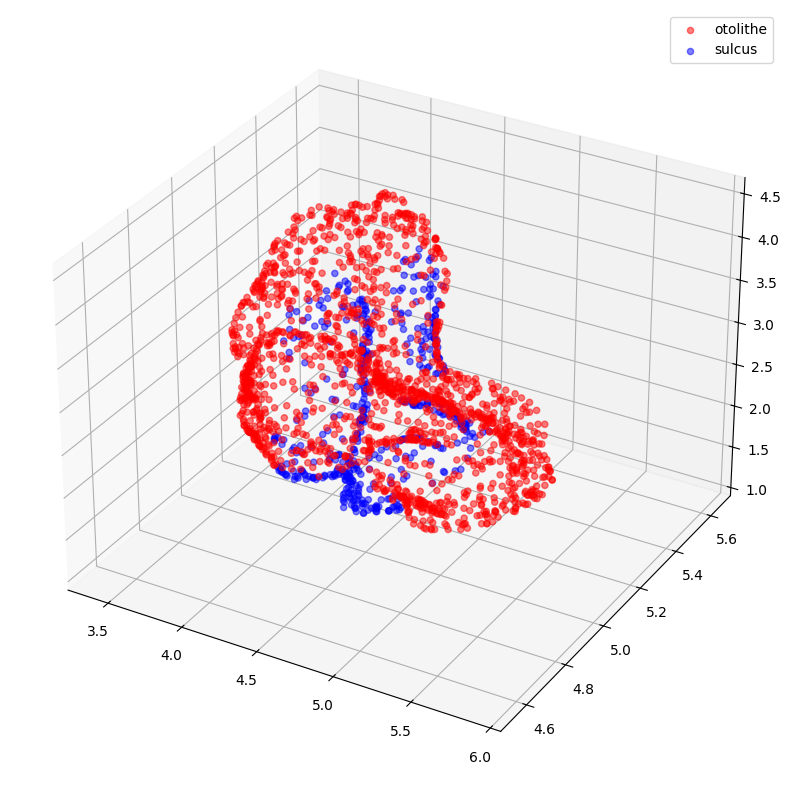

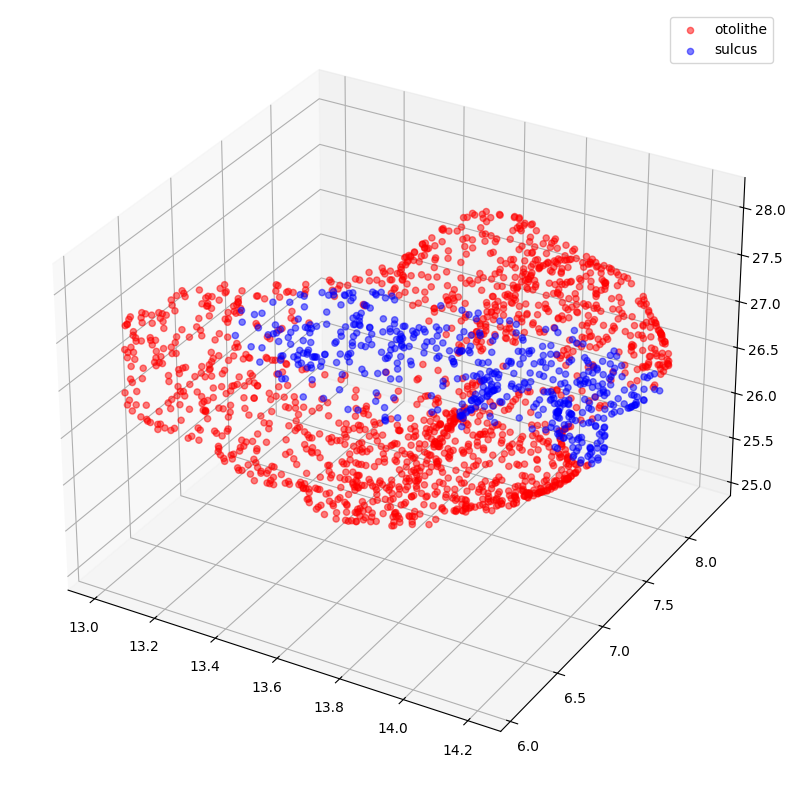

In [152]:
import pandas as pd
import matplotlib.pyplot as plt

COLORS = ["red", "blue"]

def visualize_data(point_cloud, labels):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )

    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")

    for index, label in enumerate(np.unique(labels)):  # Iterate over unique labels
        c_df = df[df["label"] == label]
        ax.scatter(
            c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index]
        )

    ax.legend()
    plt.show()

# Example usage with corrected indexing:
visualize_data(train_points[0], all_labels[0])
visualize_data(train_points[15], all_labels[15])

In [153]:
import random


for index in tqdm(range(len(train_points))):
    current_point_cloud = train_points[index]
    current_label_cloud = point_cloud_labels[index]
    current_labels = all_labels[index]
    num_points = len(current_point_cloud)
    # Randomly sampling respective indices.
    # sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    sampled_indices = list(range(num_points))
    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization.
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud.
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    train_points[index] = norm_point_cloud
    point_cloud_labels[index] = sampled_label_cloud
    all_labels[index] = sampled_labels

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:00<00:00, 24.96it/s]


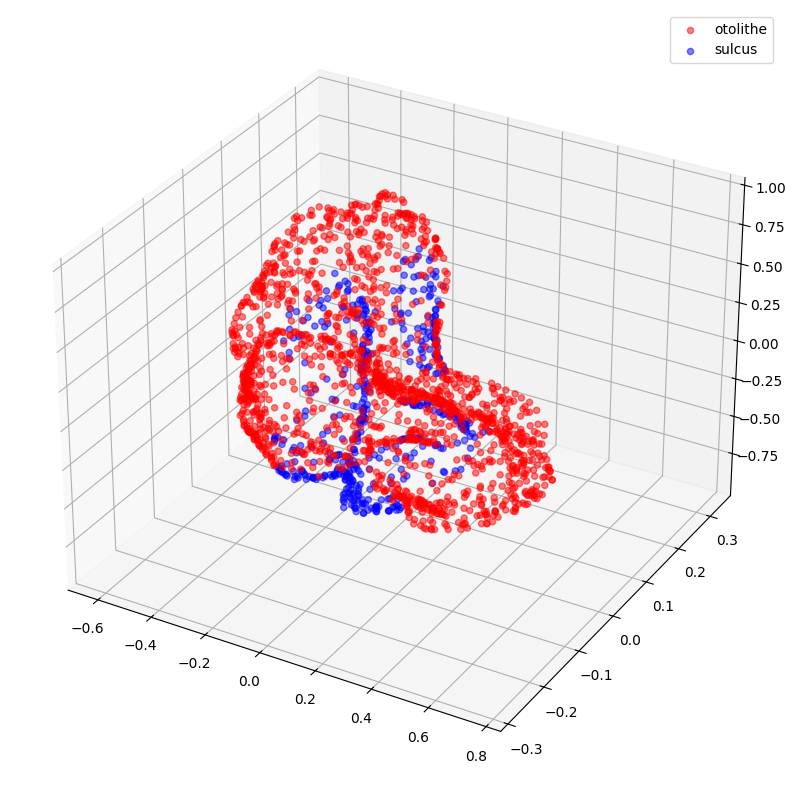

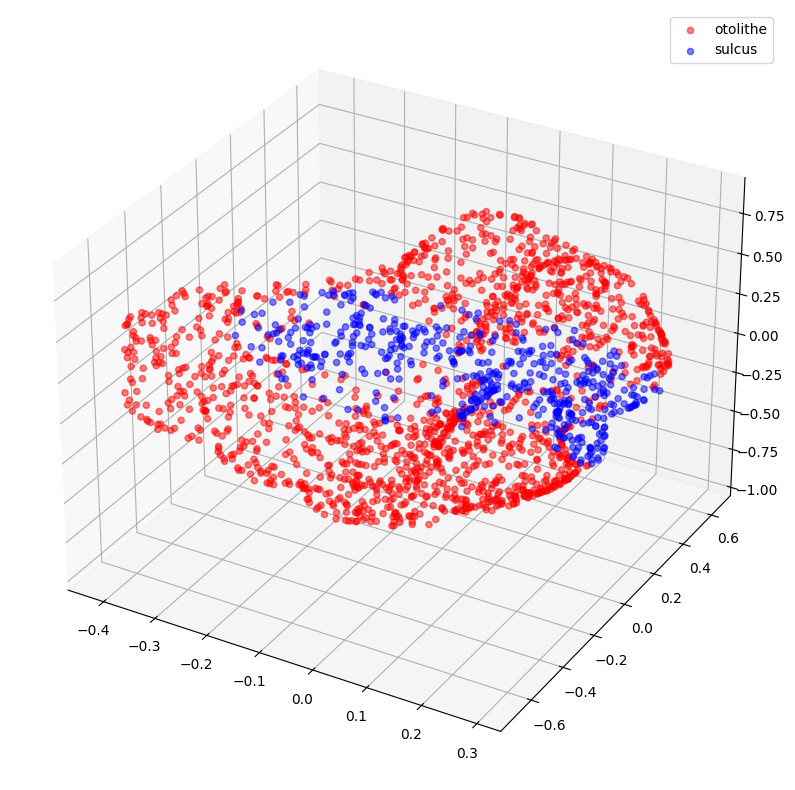

In [154]:
visualize_data(train_points[0], all_labels[0])
visualize_data(train_points[15], all_labels[15])

In [155]:
def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([NUM_SAMPLE_POINTS, 3])
    label_cloud_batch.set_shape([NUM_SAMPLE_POINTS, len(LABELS) + 1])
    return point_cloud_batch, label_cloud_batch


def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(
        tf.shape(label_cloud_batch), -0.001, 0.001, dtype=tf.float64
    )
    point_cloud_batch += noise[:, :, :3]
    return point_cloud_batch, label_cloud_batch


def generate_dataset(point_clouds, label_clouds, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    dataset = dataset.shuffle(BATCH_SIZE * 100) if is_training else dataset
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = (
        dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training
        else dataset
    )
    return dataset


split_index = int(len(train_points) * (1 - VAL_SPLIT))
train_point_clouds = train_points[:split_index]
train_label_cloud = point_cloud_labels[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = train_points[split_index:]
val_label_cloud = point_cloud_labels[split_index:]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Num train point clouds: 18
Num train point cloud labels: 18
Num val point clouds: 5
Num val point cloud labels: 5
Train Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 2048, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2048, 3), dtype=tf.float64, name=None))>
Validation Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 2048, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2048, 3), dtype=tf.float64, name=None))>


In [156]:
def conv_block(x, filters, name):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


def mlp_block(x, filters, name):
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

In [157]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = keras.ops.eye(num_features)

    def __call__(self, x):
        x = keras.ops.reshape(x, (-1, self.num_features, self.num_features))
        xxt = keras.ops.tensordot(x, x, axes=(2, 2))
        xxt = keras.ops.reshape(xxt, (-1, self.num_features, self.num_features))
        return keras.ops.sum(self.l2reg * keras.ops.square(xxt - self.identity))

    def get_config(self):
        config = super().get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config

In [158]:
def transformation_net(inputs, num_features, name):
    """
    Reference: https://keras.io/examples/vision/pointnet/#build-a-model.

    The `filters` values come from the original paper:
    https://arxiv.org/abs/1612.00593.
    """
    x = conv_block(inputs, filters=64, name=f"{name}_1")
    x = conv_block(x, filters=128, name=f"{name}_2")
    x = conv_block(x, filters=1024, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=512, name=f"{name}_1_1")
    x = mlp_block(x, filters=256, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def transformation_block(inputs, num_features, name):
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])

In [159]:
def get_shape_segmentation_model(num_points, num_classes):
    input_points = keras.Input(shape=(None, 3))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=3, name="input_transformation_block"
    )
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block(
        features_128_2, num_features=128, name="transformed_features"
    )
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = keras.ops.tile(global_features, [1, num_points, 1])

    # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return keras.Model(input_points, outputs)

In [160]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, None, 3)   │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None, 64)  │     256 │ input_layer_12[0][0] │
│ (Conv1D)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None, 64)  │     256 │ input_transformatio… │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None, 64)  │       0 │ input_transformatio… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None, 128) │   8,320 │ input_transformatio… │
│ (Conv1D)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None, 128) │     512 │ input_transformatio… │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None, 128) │       0 │ input_transformatio… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None,      │ 132,096 │ input_transformatio… │
│ (Conv1D)            │ 1024)             │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None,      │   4,096 │ input_transformatio… │
│ (BatchNormalizatio… │ 1024)             │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None,      │       0 │ input_transformatio… │
│ (Activation)        │ 1024)             │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_max_pooling… │ (None, 1024)      │       0 │ input_transformatio… │
│ (GlobalMaxPooling1… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, 512)       │ 524,800 │ global_max_pooling1… │
│ (Dense)             │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, 512)       │   2,048 │ input_transformatio… │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, 512)       │       0 │ input_transformatio… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, 256)       │ 131,328 │ input_transformatio… │
│ (Dense)             │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, 256)       │   1,024 │ input_transformatio… │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, 256)       │       0 │ input_transformatio

 Total params: 7,369,804 (28.11 MB)

 Trainable params: 7,355,852 (28.06 MB)

 Non-trainable params: 13,952 (54.50 KB)

Steps per epoch: 9.
Total training steps: 450.


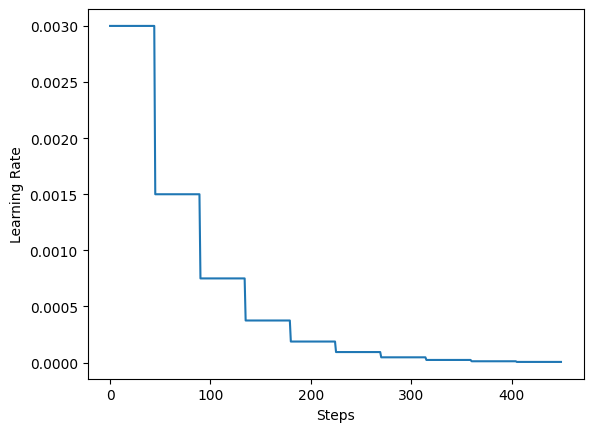

In [161]:
steps_per_epoch = total_training_examples // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS
print(f"Steps per epoch: {steps_per_epoch}.")
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=steps_per_epoch * 5,
    decay_rate=0.5,
    staircase=True,
)

steps = range(total_training_steps)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [162]:
def run_experiment(epochs):
    segmentation_model = get_shape_segmentation_model(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 934ms/step - accuracy: 0.5270 - loss: 61.8135 - val_accuracy: 0.7164 - val_loss: 1.5678
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 701ms/step - accuracy: 0.6972 - loss: 19.1401 - val_accuracy: 0.7068 - val_loss: 7.0103
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 715ms/step - accuracy: 0.7160 - loss: 7.0100 - val_accuracy: 0.6047 - val_loss: 5.2408
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 709ms/step - accuracy: 0.7395 - loss: 3.1983 - val_accuracy: 0.6173 - val_loss: 10.7972
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 717ms/step - accuracy: 0.6595 - loss: 5.4958 - val_accuracy: 0.7068 - val_loss: 11.2832
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 724ms/step - accuracy: 0.7169 - loss: 2.1213 - val_accuracy: 0.6608 - val_loss: 12.8938
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 714ms/step - accuracy: 0.7265 - loss: 1.8862 - val_accuracy: 0.3232 - val_loss: 14.4848
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 710ms/step - accuracy: 0.7188 - loss: 1.5682 - val_accuracy: 0.7068 - va

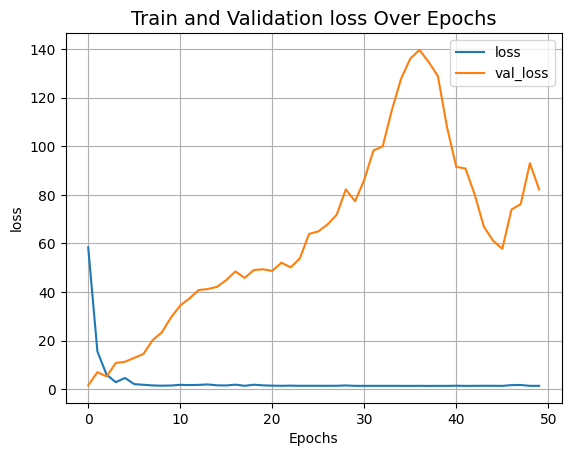

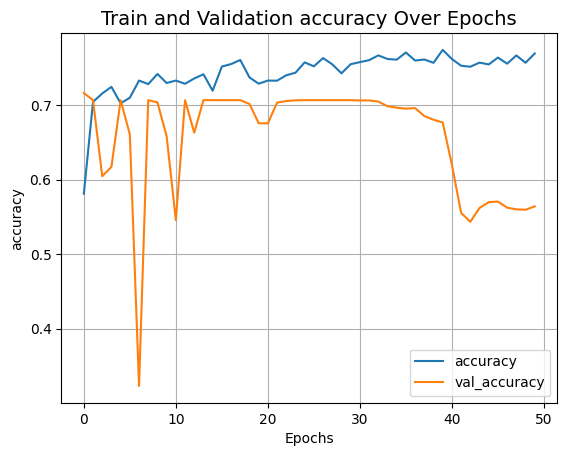

In [163]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
Validation prediction shape: (2, 2048, 3)
Index selected: 0


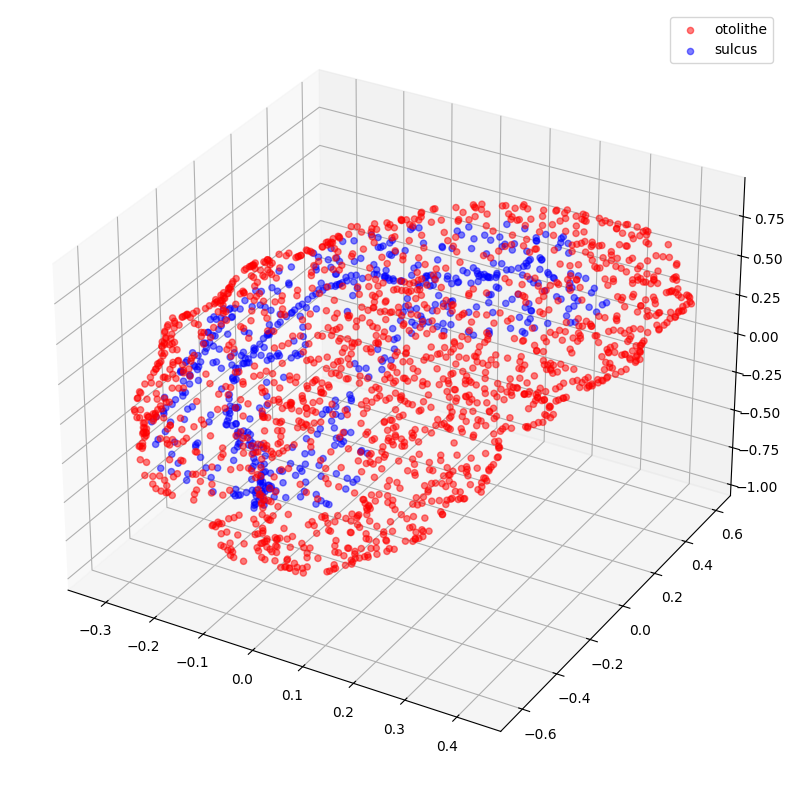

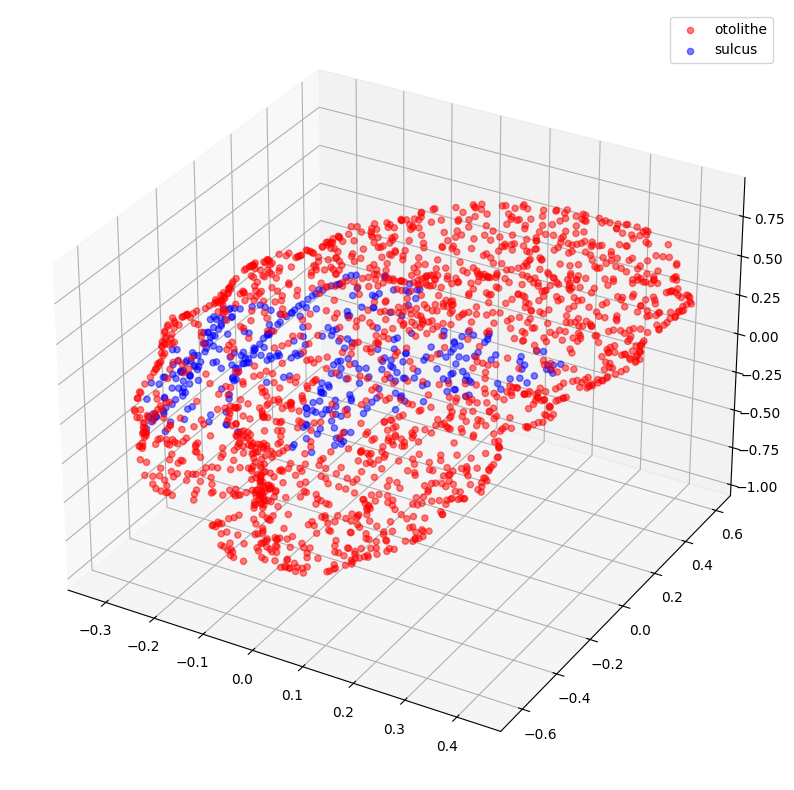

In [167]:
validation_batch = next(iter(val_dataset))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")


def visualize_single_point_cloud(point_clouds, label_clouds, idx):
    label_map = LABELS + ["none"]
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualize_data(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx)

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], val_predictions, idx)